In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/construction-budgets-activity-and-dates/constructionbudgets.csv


# Matplotlib Visualization

In [90]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [91]:
budgets = pd.read_csv('/kaggle/input/construction-budgets-activity-and-dates/constructionbudgets.csv')
budgets

,Activity ID,Activity Name,WBS Name,Planned Start,Planned Finish,Budgeted Total Cost
0,A3150,Cabinets/Telecom Rooms,Civil works,18-Jul-23,2-Aug-23,"30,000.00"
1,A3590,Project Start Date,Milestones,18-Jul-23,19-Jul-23,0
2,A3610,Prepare and Submitt Cabins Design {Schematic D...,Submit for approval Schematic Designs,18-Jul-23,25-Jul-23,"3,857.00"
3,A3650,Set Offices,Mobilization,18-Jul-23,25-Jul-23,0
4,A2260,10 watts PA Horn Speaker Indoor type,ELV works,19-Jul-23,2-Aug-23,"2,700.00"
...,...,...,...,...,...,...
306,A3400,Wet utilities Water tank (burried),Wet utilties works,27-Jun-24,4-Jul-24,"18,000.00"
307,A3660,Testing & Commissioning,Testing & Commissioning,4-Jul-24,11-Jul-24,0
308,A3600-10,Construction Finish Date,Milestones,NaN,4-Jul-24,0
309,A3670,Handover,Hanover,11-Jul-24,16-Jul-24,0


In [92]:
df = pd.DataFrame(budgets)

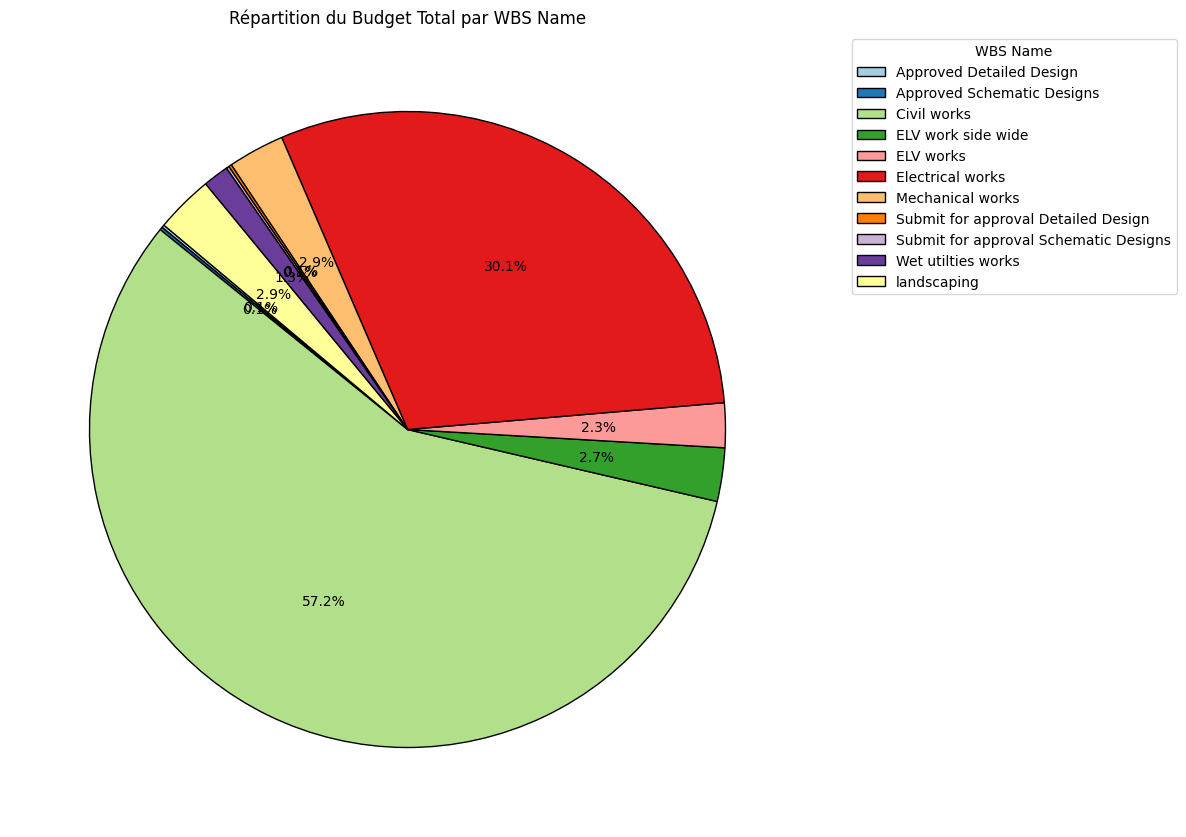

In [93]:
# Convert "Budgeted Total Cost" to numeric (remove commas and convert to float)
df["Budgeted Total Cost"] = df["Budgeted Total Cost"].str.replace(",", "").astype(float)

# Group by "WBS Name" and sum the budgeted costs
wbs_budget = df.groupby("WBS Name")["Budgeted Total Cost"].sum()

# Remove zero values (if any) to avoid chart errors
wbs_budget = wbs_budget[wbs_budget > 0]

# Pie Chart
fig, ax = plt.subplots(figsize=(12, 12))
wedges, _, autotexts = ax.pie(
    wbs_budget,
    autopct="%1.1f%%",  # Show percentages
    startangle=140,
    colors=plt.cm.Paired.colors,  # Use different colors
    wedgeprops={"edgecolor": "black"}  # Add border for clarity
)

# Add a legend instead of labels
plt.legend(wedges, wbs_budget.index, title="WBS Name", bbox_to_anchor=(1.05, 1), loc="upper left")

# Title and layout
plt.title("Répartition du Budget Total par WBS Name")
plt.tight_layout()  # Adjust layout to prevent overlap

# Show plot
plt.show()

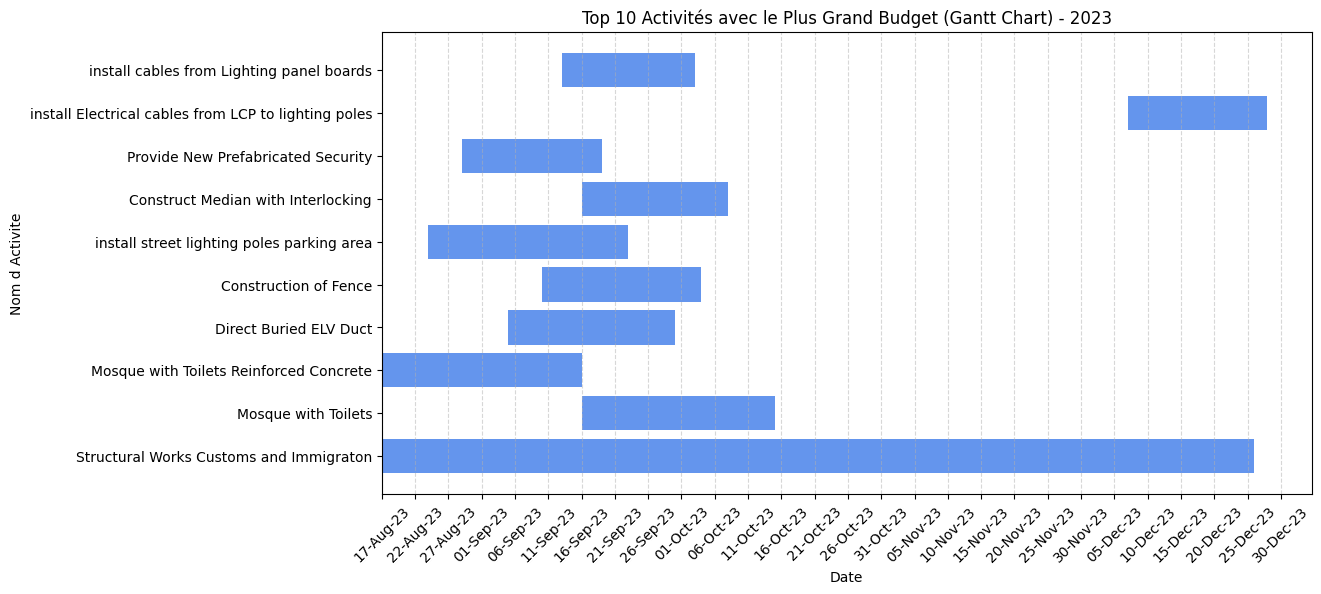

In [94]:
# Convert dates to datetime format
df["Planned Start"] = pd.to_datetime(df["Planned Start"], format="%d-%b-%y")
df["Planned Finish"] = pd.to_datetime(df["Planned Finish"], format="%d-%b-%y")

# Filter only activities that start and finish in 2023
df_2023 = df[(df["Planned Start"].dt.year == 2023) & (df["Planned Finish"].dt.year == 2023)].copy()

# Select the top 10 activities with the highest budget
df_2023["Budgeted Total Cost"] = pd.to_numeric(df_2023["Budgeted Total Cost"], errors="coerce")
df_top10 = df_2023.nlargest(10, "Budgeted Total Cost").copy()

# Compute durations
df_top10["Duration"] = (df_top10["Planned Finish"] - df_top10["Planned Start"]).dt.days

# --- 📅 Visualization: Gantt Chart for Top 10 Highest Budget Activities ---
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each activity
for i, row in df_top10.iterrows():
    ax.barh(row["Activity Name"], row["Duration"], left=row["Planned Start"], color="cornflowerblue")

# Format x-axis for dates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b-%y"))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)

# Labels and title
plt.xlabel("Date")
plt.ylabel("Nom d Activite")
plt.title("Top 10 Activités avec le Plus Grand Budget (Gantt Chart) - 2023")
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Show plot
plt.show()

# machine learning

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


<ipython-input-107-05d5cd75eb30>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Activity Name"].fillna("Unknown", inplace=True)  # Fill missing text with "Unknown"
<ipython-input-107-05d5cd75eb30>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[

MAE: 36111.15
RMSE: 72386.81
R² Score: 0.45


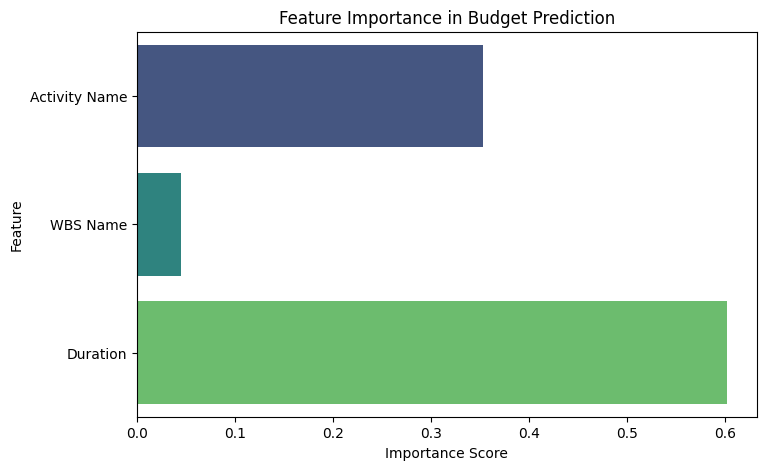

In [107]:
# Convert to DataFrame
df = pd.DataFrame(budgets)

# 🛠️ **Preprocessing**
# Convert "Budgeted Total Cost" to numeric
df["Budgeted Total Cost"] = df["Budgeted Total Cost"].str.replace(",", "").astype(float)

# Convert dates
df["Planned Start"] = pd.to_datetime(df["Planned Start"], format="%d-%b-%y", errors="coerce")
df["Planned Finish"] = pd.to_datetime(df["Planned Finish"], format="%d-%b-%y", errors="coerce")

# Compute Duration
df["Duration"] = (df["Planned Finish"] - df["Planned Start"]).dt.days

# Handling Missing Values 🔥
df["Activity Name"].fillna("Unknown", inplace=True)  # Fill missing text with "Unknown"
df["Planned Start"].fillna(df["Planned Start"].median(), inplace=True)  # Fill dates with median
df["Planned Finish"].fillna(df["Planned Finish"].median(), inplace=True)
df["Budgeted Total Cost"].fillna(df["Budgeted Total Cost"].mean(), inplace=True)  # Fill budget with mean
df["Duration"].fillna(df["Duration"].median(), inplace=True)  # Fill missing durations with median

# Encode categorical variables
label_enc = LabelEncoder()
df["Activity Name"] = label_enc.fit_transform(df["Activity Name"])
df["WBS Name"] = label_enc.fit_transform(df["WBS Name"])

# Define features & target
X = df[["Activity Name", "WBS Name", "Duration"]]
y = df["Budgeted Total Cost"]

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🎯 **Train Machine Learning Model (Random Forest Regressor)**
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 📊 **Predictions**
y_pred = model.predict(X_test)

# 🏆 **Evaluation**
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# 🔥 **Feature Importance Visualization**
plt.figure(figsize=(8, 5))
sns.barplot(x=model.feature_importances_, y=X.columns, palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Budget Prediction")
plt.show()